In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil.parser import parse
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("Stock_Price.csv", parse_dates=['Date'], index_col='Date')
data.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2000-03-27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
2000-03-28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2000-03-29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
2000-03-30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
2000-03-31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [3]:
df_resam = data.resample('D').mean()
df = df_resam.bfill()
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

## 	Seasonal Plot of a Time Series

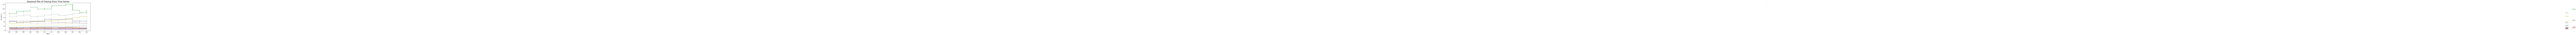

In [4]:
import matplotlib as mpl

# Prepare data
df['year'] = [d.year for d in df.index]   # The Date column is the index for the Dataframe
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(15,5))
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Close', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'Close'][-1:].values[0], y,  
        fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(ylabel='$Closing Prices$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Closing Price Time Series", fontsize=20)
plt.show()


## Decomposition of Time Series

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Multiplicative Decomposition
mul_decomp = seasonal_decompose(df.Close, model = 'multiplicative', 
                                extrapolate_trend = 'freq')

#Additive Decoposition
add_decomp = seasonal_decompose(df.Close, model = 'additive', 
                                extrapolate_trend = 'freq')

Text(0.5, 0.98, 'Multiplicative Decompose')

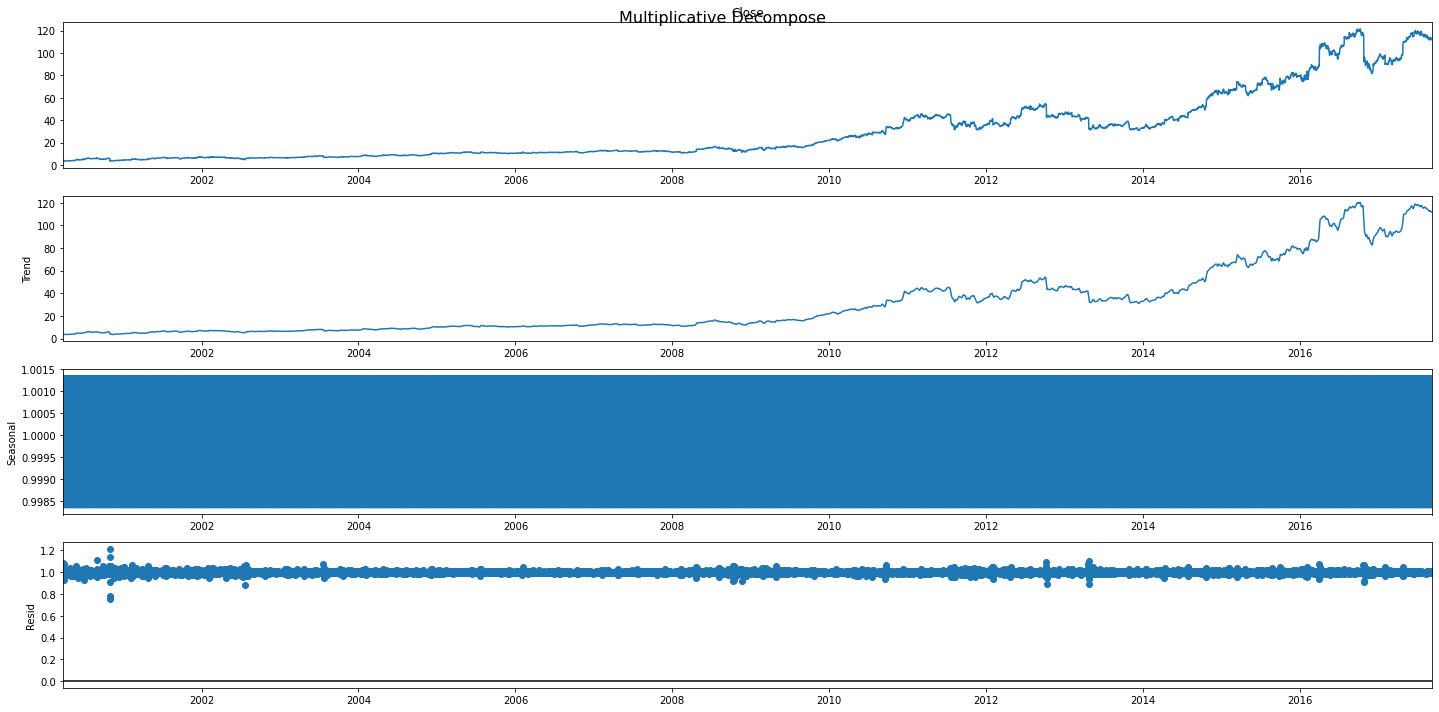

In [6]:
#Plotting

plt.rcParams.update({'figure.figsize': (20,10)})

mul_decomp.plot().suptitle('Multiplicative Decompose', fontsize = 16)

Text(0.5, 0.98, 'Additive Decompose')

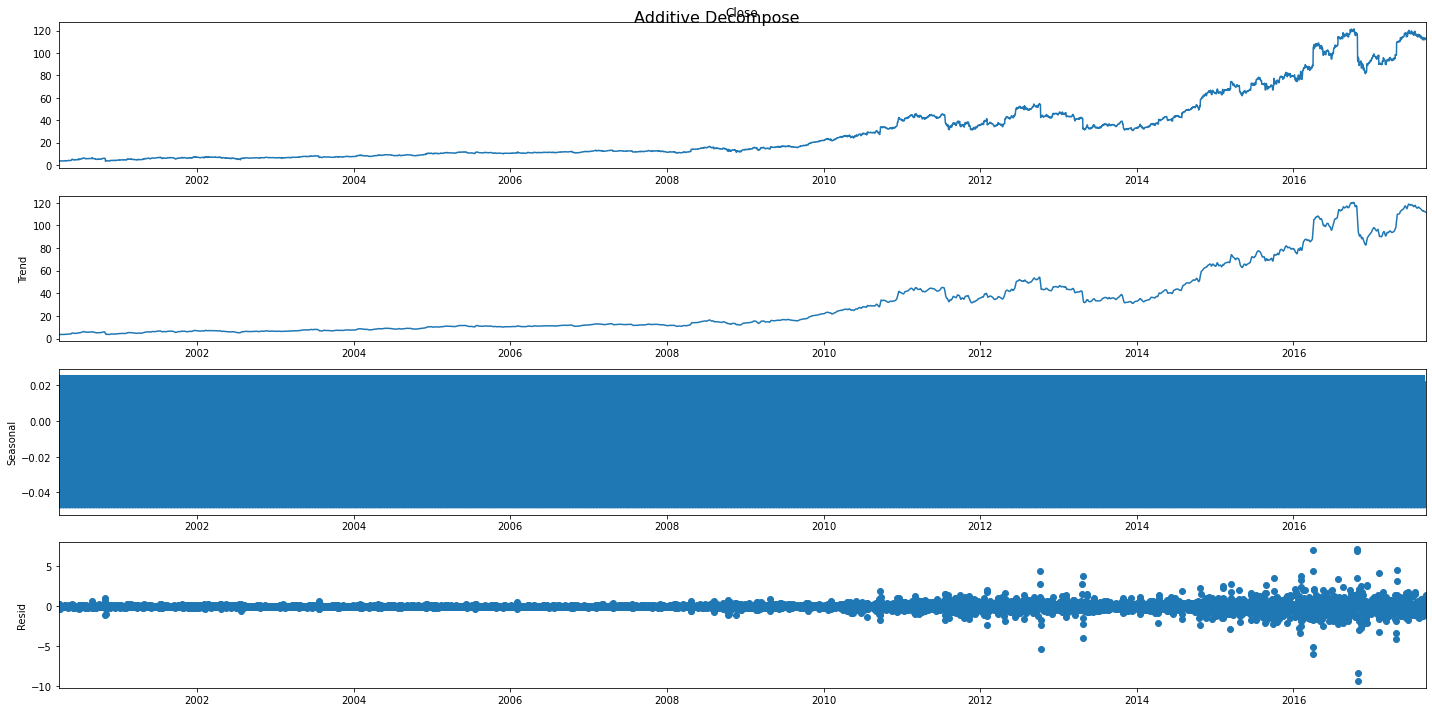

In [7]:
add_decomp.plot().suptitle('Additive Decompose', fontsize = 16)

##### There is no seasonal component to the data and also the residual in Additive decomposition has mean = 0 which means that the forecast is not biased.

## Stationarity Test

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

#ADF Test
result = adfuller(df.Close.values, autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'No. Of Lags: {result[2]}')
print('Critical Values')
for key, value in result[4].items(): 
  print(f'  {key:5} {value:10}')

ADF Statistic: 0.7629439882765348
p-value: 0.9910138449628524
No. Of Lags: 27
Critical Values
  1%    -3.431380714776405
  5%    -2.8619954857540173
  10%   -2.5670124519570336


In [9]:
#KPSS Test
result = kpss(df.Close.values, regression = 'c')
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'No. Of Lags: {result[2]}')
print('Critical Values')
for key, value in result[3].items(): 
  print(f'  {key:5} {value:10}')

KPSS Statistic: 14.105521221132465
p-value: 0.01
No. Of Lags: 34
Critical Values
  10%        0.347
  5%         0.463
  2.5%       0.574
  1%         0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


##### Based on the ADFuller and KPSS test, it is concluded that the Time Series is not stationary as p-value is higher than critical value in the former qand p-value is lesser that critical value in the later

## Detrending the Time Series 

Text(0.5, 1.0, 'Detrended Time Series')

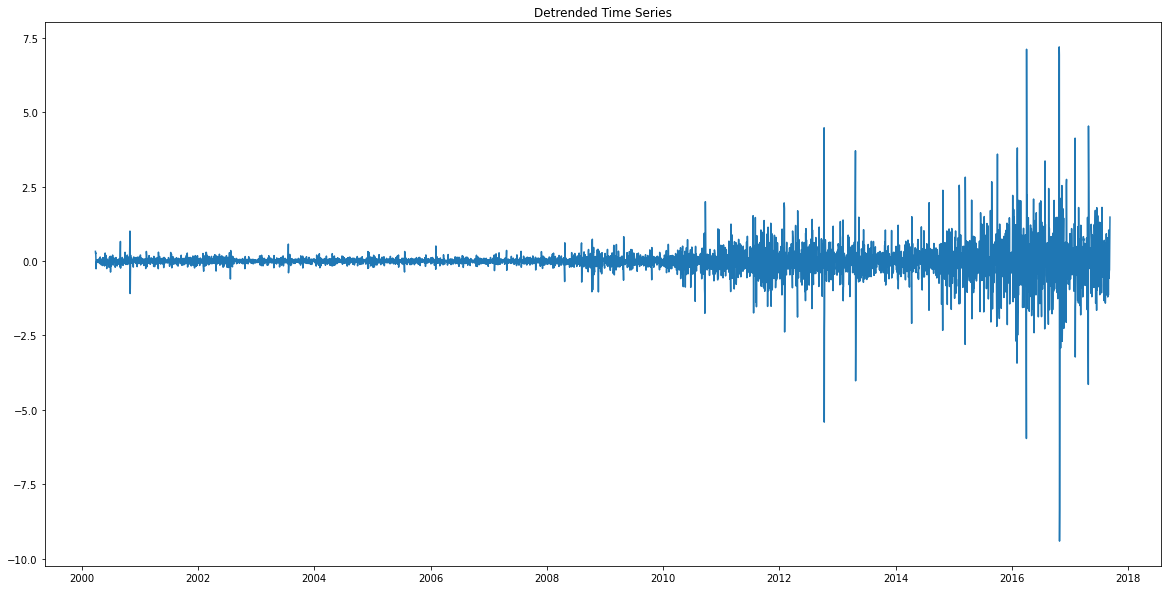

In [10]:
# Substractin the trend component from the series

detrended = df.Close.values - mul_decomp.trend
plt.plot(detrended)
plt.title('Detrended Time Series')

## Deseasonlizing Time Series

Text(0.5, 1.0, 'Deseasoned Time Series')

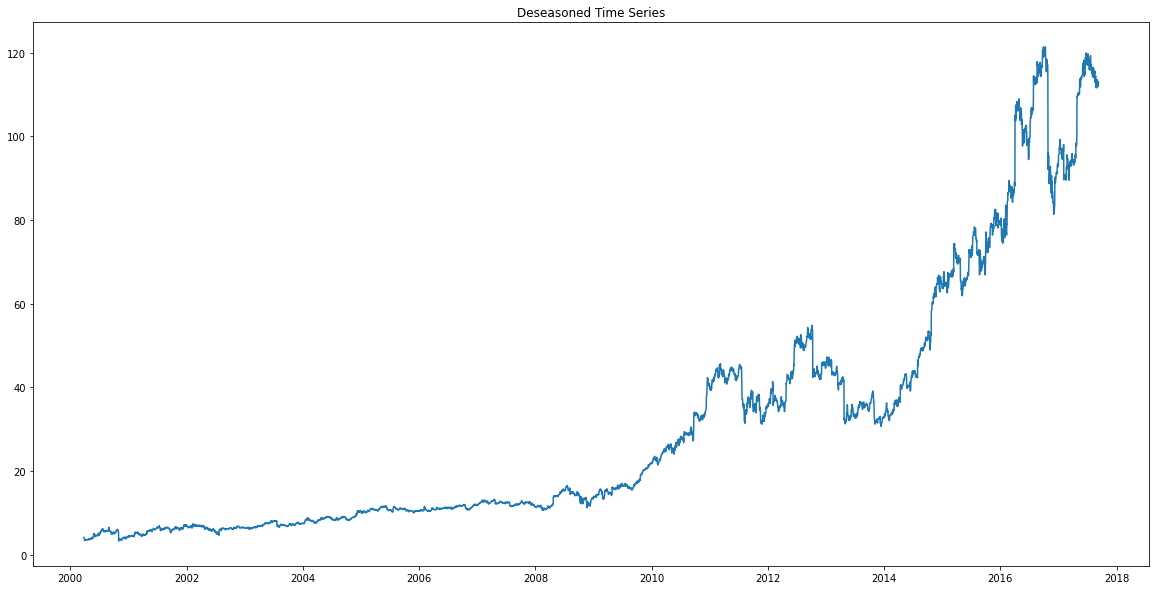

In [11]:
# Deseasonalising by diving the series by the seasonal index

deseasoned = df.Close.values/mul_decomp.seasonal
plt.plot(deseasoned)
plt.title('Deseasoned Time Series')

## Autocorrelation and Partial Autocorrelation

In [12]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [13]:
df.Close.values

array([  4.125   ,   4.015625,   4.      , ..., 112.230003, 112.339996,
       113.190002])

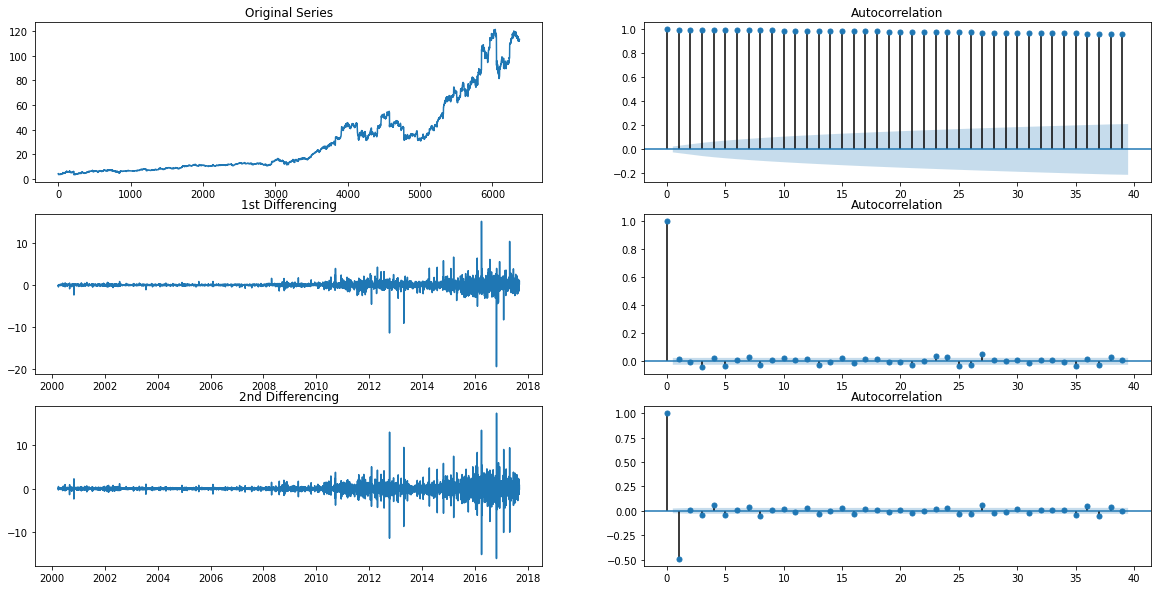

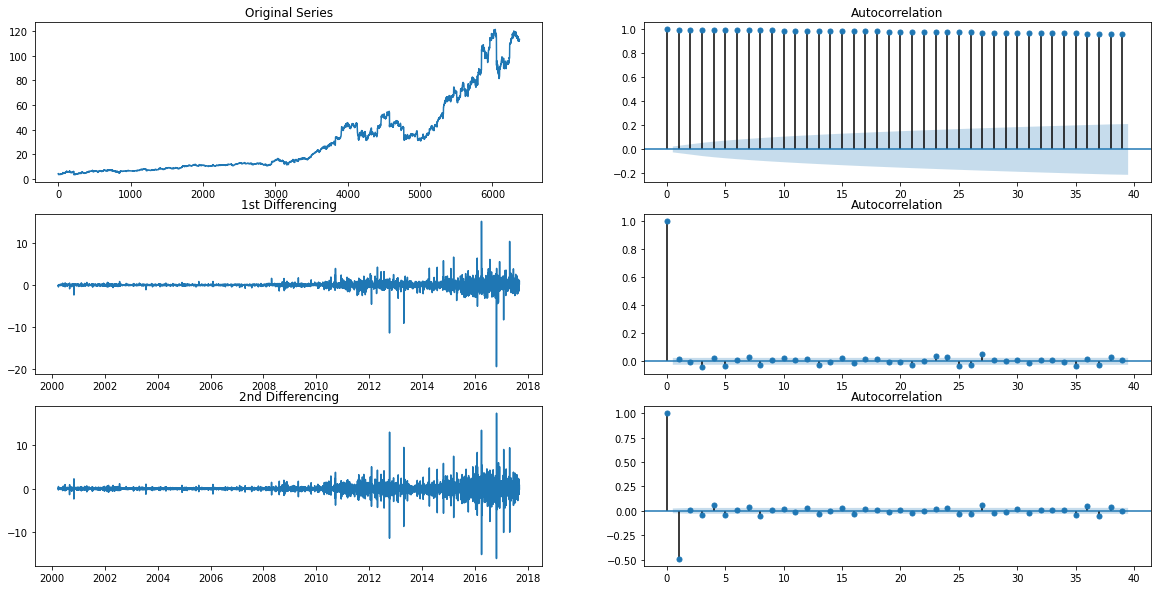

In [14]:
# ACF plot finding the differencing (d)

fig, axes = plt.subplots(3,2)

#Original Data
axes[0,0].plot(df.Close.values); axes[0,0].set_title("Original Series")
plot_acf(df.Close, ax = axes[0,1])

#1st Differencing
axes[1,0].plot(df.Close.diff()); axes[1,0].set_title("1st Differencing")
plot_acf(df.Close.diff().dropna(), ax = axes[1,1])

#2nd Differencing
axes[2,0].plot(df.Close.diff().diff()); axes[2,0].set_title("2nd Differencing")
plot_acf(df.Close.diff().diff().dropna(), ax = axes[2,1])

#### The Autocorrelation grah for 2nd differencing goes negative pretty quickly, so will use d =1 

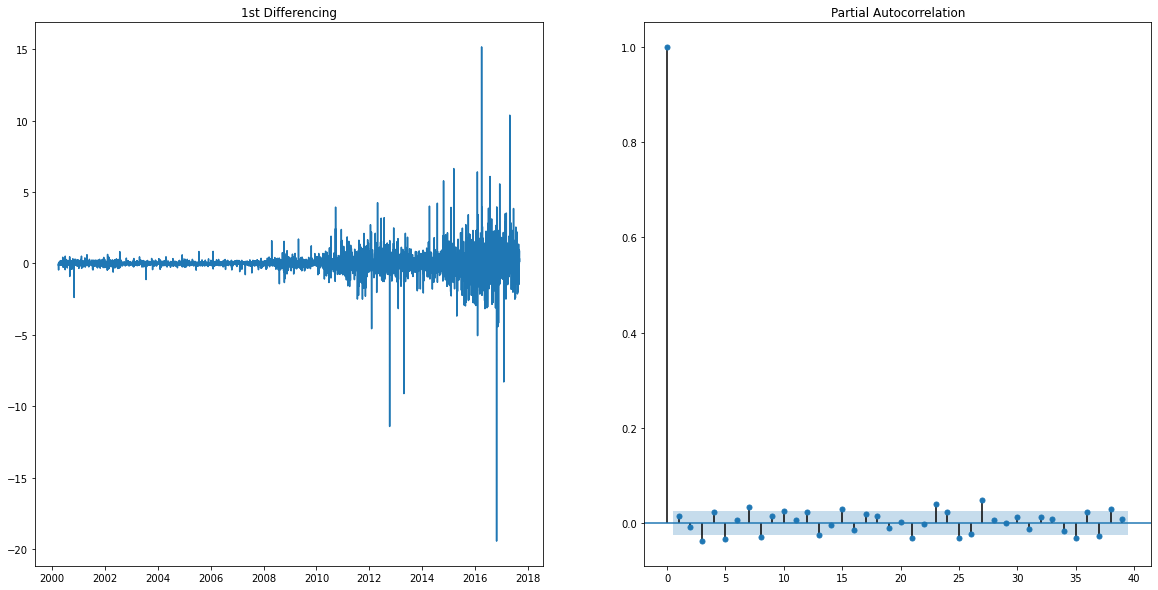

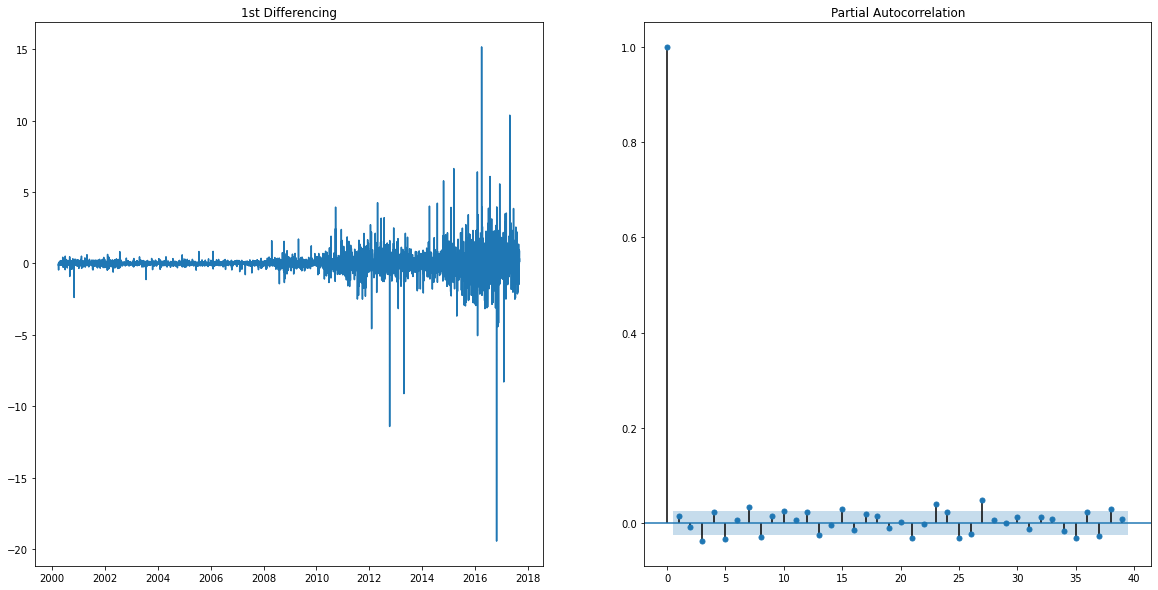

In [15]:
# PACF plot to find the number of lags (p)

fig, ax = plt.subplots(1,2)
ax[0].plot(df.Close.diff()); ax[0].set_title("1st Differencing")
plot_pacf(df.Close.diff().dropna() , ax = ax[1])

#### Only 1 tick is above the significance line so p = 1

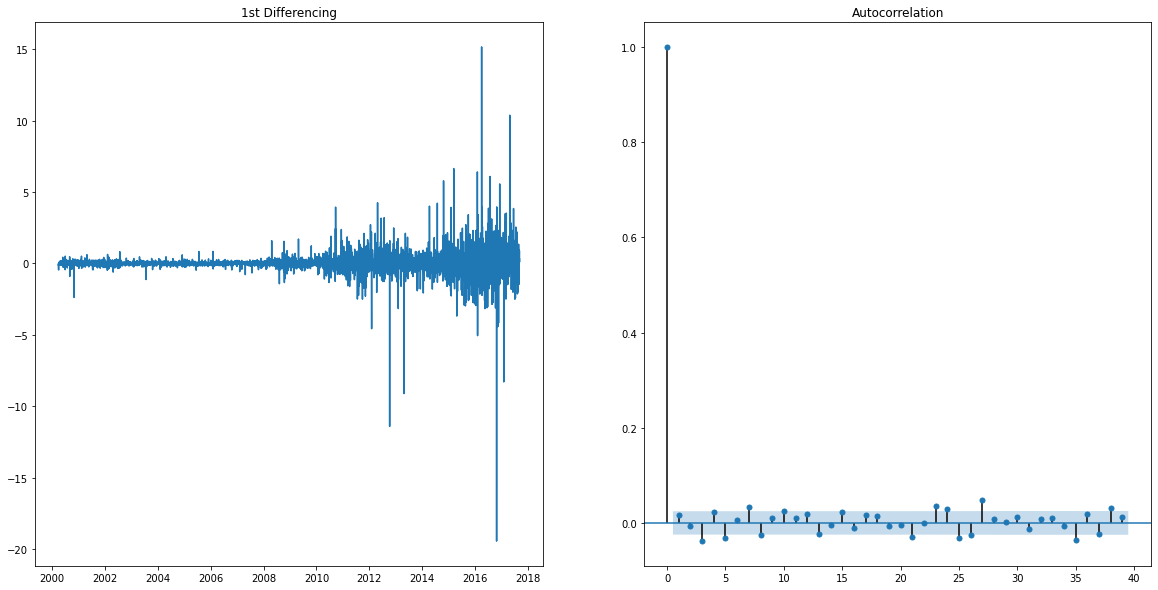

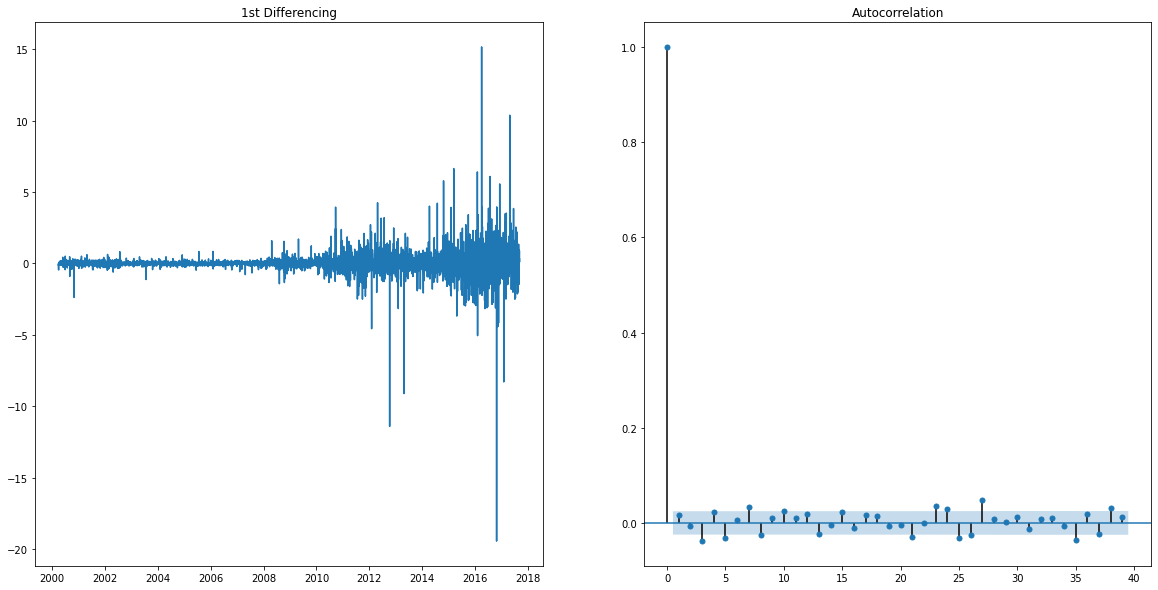

In [16]:
# ACF plot to find the moving average (q)

fig, ax = plt.subplots(1,2)
ax[0].plot(df.Close.diff()); ax[0].set_title("1st Differencing")
plot_acf(df.Close.diff().dropna() , ax = ax[1])

#### Only 1 tick is above the significance line so q = 1

## ARIMA Model

In [17]:
# (1,1,1) Arima Model

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df.Close, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6374
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6616.400
Method:                       css-mle   S.D. of innovations              0.683
Date:                Sun, 18 Sep 2022   AIC                          13240.799
Time:                        14:30:54   BIC                          13267.839
Sample:                    03-28-2000   HQIC                         13250.161
                         - 09-08-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0171      0.009      1.970      0.049    8.66e-05       0.034
ar.L1.D.Close    -0.0600      0.306     -0.196      0.845      -0.660       0.540
ma.L1.D.Close     0.0760      0.305     

In [18]:
# (2,1,1) Arima Model
model = ARIMA(df.Close, order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6374
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -6615.068
Method:                       css-mle   S.D. of innovations              0.683
Date:                Sun, 18 Sep 2022   AIC                          13240.136
Time:                        14:30:55   BIC                          13273.936
Sample:                    03-28-2000   HQIC                         13251.838
                         - 09-08-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0171      0.008      2.048      0.041       0.001       0.033
ar.L1.D.Close     0.5907      0.218      2.710      0.007       0.164       1.018
ar.L2.D.Close    -0.0259      0.013     

In [19]:
# (2,1,2) Arima Model
model = ARIMA(df.Close, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6374
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6614.228
Method:                       css-mle   S.D. of innovations              0.683
Date:                Sun, 18 Sep 2022   AIC                          13240.455
Time:                        14:30:57   BIC                          13281.015
Sample:                    03-28-2000   HQIC                         13254.498
                         - 09-08-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0171      0.008      2.051      0.040       0.001       0.033
ar.L1.D.Close     0.8992      0.437      2.057      0.040       0.043       1.756
ar.L2.D.Close    -0.3804      0.278     

#### (2,1,1) looks good because P>|z| is below the critical value and AIC score is smaller than the other 2

In [20]:
# (2,1,1) Arima Model
model = ARIMA(df.Close, order=(2,1,1))
model_fit = model.fit(disp=0)

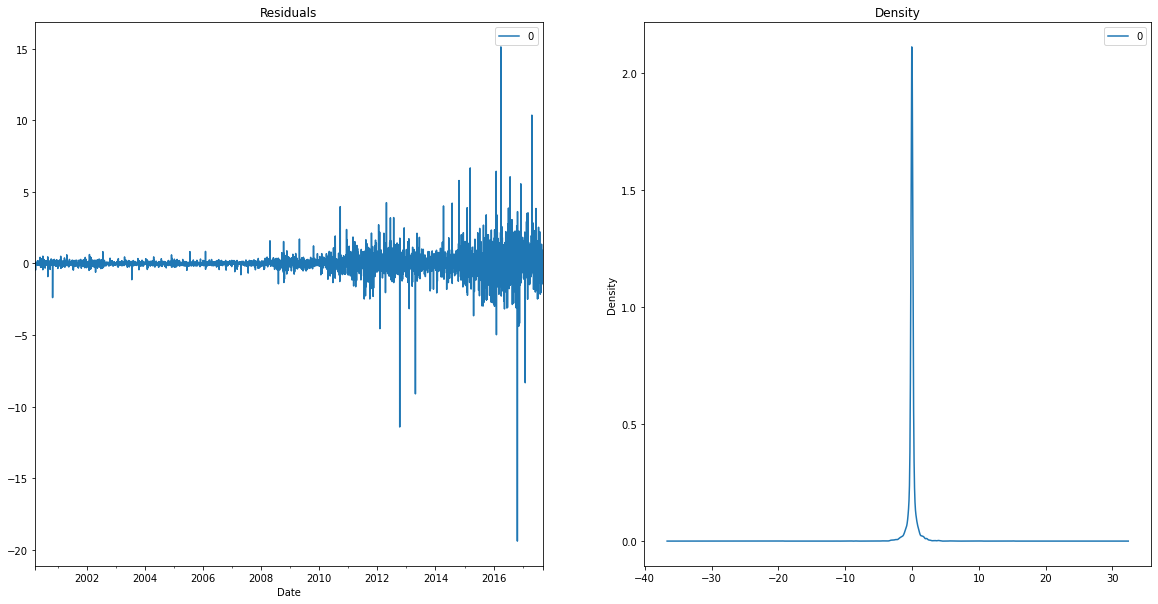

In [21]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

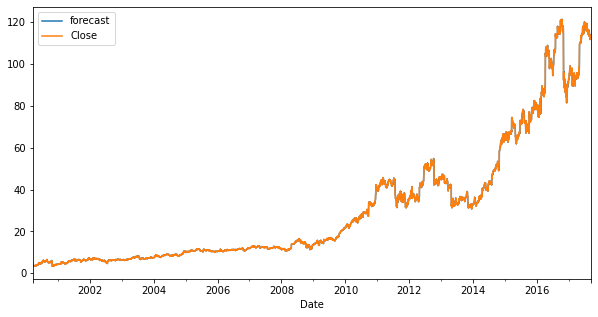

In [22]:
plt.rcParams['figure.figsize'] = (10,5)

# Actual vs Fitted
model_fit.plot_predict(dynamic = False)
plt.show()

## Optimal ARIMA model using Out-of-Time Cross Validation

In [23]:
len = int(df.shape[0] * 0.8)
print(len)

5100


In [29]:
df.shape[0] - len

1275

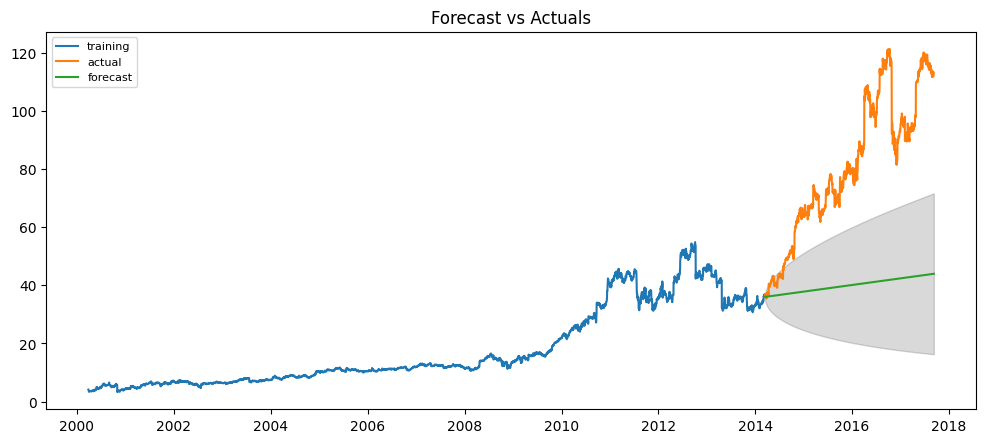

In [33]:
# Create Train and Test set
train = df.Close[:len]
test = df.Close[len:]

#Build Model
model = ARIMA(train, order = (2,1,1))
model_fit = model.fit(disp = -1)

#Forecast
fc, se, conf = model_fit.forecast(1275, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

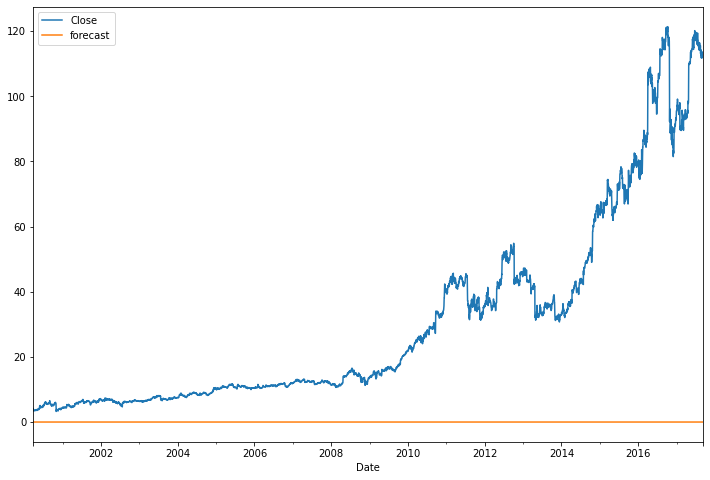

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=SARIMAX(df['Close'],order=(2, 1, 1),seasonal_order=(2,1,1,12))
results=model.fit()
df['forecast']=results.predict(dynamic=True)
df[['Close','forecast']].plot(figsize=(12,8))